In [1]:
import numpy as np
import math
from scipy.stats import norm
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy.stats import unitary_group
import random
import scipy.integrate as spi

In [41]:
sigma_space = np.logspace(-1,1,100)
thresh_space = np.linspace(-5,5,100)
M =1
mu = 0
sigma_teta = (1/math.sqrt(2))
rho_q = 1
rho_a = 1
########Teta
real_teta = np.random.normal(mu, sigma_teta,M)
im_teta = np.random.normal(mu, sigma_teta,M)
teta = real_teta + 1j*im_teta
teta = teta.reshape(M,1)

In [3]:
def Matrix(na,nq): #new model
    H_mat = np.zeros((na*M,M), complex)
    G_mat = np.zeros((nq*M,M), complex)
    for i in range(0,na*M,M):
        if M>1:
            H_mat[i:M+i,:] = math.sqrt(rho_a)*unitary_group.rvs(M)
        else:
            x1 = random.random()
            y1 = math.sqrt(1 - pow(x1, 2))
            H_mat[i:M + i, :] = math.sqrt(rho_a)*(x1+1j*y1)
    for i in range(0,nq*M,M):
        if M > 1:
            G_mat[i:M+i,:] = math.sqrt(rho_q)*unitary_group.rvs(M)
        else:
            x2 = random.random()
            y2 = np.sqrt(1 - np.power(x2, 2))
            G_mat[i:M + i, :] = math.sqrt(rho_a)*(x2 + 1j * y2)
    return H_mat, G_mat

In [4]:
def thresh_G(n_q, Mat):
    if M>1:
        G_teta=Mat@((mu+1j*mu)*np.ones(M))
    else:
        G_teta=Mat*((mu+1j*mu)*np.ones(M))
    return G_teta.real.reshape(M*n_q, 1), G_teta.imag.reshape(M*n_q, 1)

In [5]:
def x(sigma, n_a,n_q, matrix,thresh_real,thresh_im): #the observations- function of teta
    sigma_w_a = sigma * (1 / math.sqrt(2))
    real_w_a = np.random.normal(mu, sigma_w_a, M*n_a)
    im_w_a = np.random.normal(mu, sigma_w_a, M*n_a)
    w_a = real_w_a + 1j * im_w_a
    w_a = w_a.reshape(M*n_a, 1)

    sigma_w_q = sigma * (1 / math.sqrt(2))
    real_w_q = np.random.normal(mu, sigma_w_q, M*n_q)
    im_w_q = np.random.normal(mu, sigma_w_q, M*n_q)
    w_q = real_w_q + 1j * im_w_q
    w_q = w_q.reshape(M*n_q, 1)

    if M>1:
        x_a = matrix[0]@teta + w_a
        y = matrix[1]@teta + w_q
    else:
        x_a = matrix[0]*teta + w_a
        y = matrix[1]*teta + w_q

    x_q = (1 / math.sqrt(2)) * (np.sign(y.real - (thresh_real) +
                            1j * np.sign(y.imag - ((thresh_im)))))
    return x_a.reshape(M*n_a, ), x_q.reshape(M*n_q, )

def samp(sigma, n_a,n_q, matrix, observ,thresh_real,thresh_im): #samples
    sigma_teta_samp = (1/math.sqrt(2))
    real_teta_samp = np.random.normal(mu, sigma_teta_samp, (M,observ))
    im_teta_samp = np.random.normal(mu, sigma_teta_samp, (M,observ))
    teta_samp = real_teta_samp + 1j*im_teta_samp

    sigma_w_a_samp = sigma * (1 / math.sqrt(2))
    real_w_a_samp = np.random.normal(mu, sigma_w_a_samp, (M*n_a,observ))
    im_w_a_samp = np.random.normal(mu, sigma_w_a_samp, (M*n_a,observ))
    w_a_samp = real_w_a_samp + 1j * im_w_a_samp

    sigma_w_q_samp = sigma * (1 / math.sqrt(2))
    real_w_q_samp = np.random.normal(mu, sigma_w_q_samp,(M*n_q,observ))
    im_w_q_samp = np.random.normal(mu, sigma_w_q_samp,(M*n_q,observ))
    w_q_samp = real_w_q_samp + 1j * im_w_q_samp

    x_a_samp = (matrix[0]@teta_samp)+w_a_samp
    y_samp = (matrix[1]@teta_samp) + w_q_samp

    x_q_samp = (1 / math.sqrt(2)) * (np.sign(y_samp.real - (thresh_real) +
                                        1j * np.sign(y_samp.imag - ((thresh_im)))))
    return x_a_samp, x_q_samp, teta_samp.reshape(M,observ)

def samp_teta(observ): #samples-for CRB function (d_k)
    real_teta_samp = np.random.normal(mu, sigma_teta, (M, observ))
    im_teta_samp = np.random.normal(mu, sigma_teta, (M, observ))
    teta_samp = real_teta_samp + 1j * im_teta_samp
    return  teta_samp.reshape(M,observ)

def covariance(v1,v2):
    normv1 = np.mean(v1,1)
    normv2 = np.mean(v2,1)
    v = v1-normv1.reshape(np.shape(v1)[0],1)
    u = v2 -normv2.reshape(np.shape(v2)[0],1)
    result = [v[:,i].reshape(np.shape(v)[0], 1)@u[:,i].transpose().reshape(1, np.shape(u)[0]) for i in range(np.shape(v)[1])]
    return np.mean(result,0)

In [6]:
def MSE_zertothresh_analytic(sigma, n_a,n_q):
    alpha = (2 / math.pi) * math.acos(rho_q / (rho_q + pow(sigma, 2)))
    beta = (1-alpha)/rho_q
    first = (rho_a*n_a)/(rho_a*n_a+pow(sigma, 2))
    second = (2*rho_q*n_q*pow(sigma,4))/(math.pi*(rho_q+pow(sigma, 2))*(alpha+beta*rho_q*n_q)*pow(rho_a*n_a+pow(sigma, 2),2))
    return math.sqrt(M)*(1-first-second) #Frobenius  norm

def MSE_general_numerical(sigma, n_a,n_q, matrix, observ,thresh_real,thresh_im):
    cov = np.zeros((observ, M, M))
    for i in range(observ):
        x_a_vec, x_q_vec, teta_vec = samp(sigma, n_a,n_q, matrix, observ,thresh_real,thresh_im)
        mat1 = np.concatenate((covariance(x_a_vec,x_a_vec), covariance(x_a_vec,x_q_vec)),axis=1)
        mat2 = np.concatenate((covariance(x_q_vec,x_a_vec), covariance(x_q_vec,x_q_vec)),axis=1)
        cov_x = np.concatenate((mat1, mat2),axis=0)
        cov_teta_x = np.concatenate((covariance(teta_vec,x_a_vec), covariance(teta_vec,x_q_vec)),axis=1)
        cov_x = cov_x + 0.00001*np.identity(cov_x.shape[0])
        cov_x_inv =LA.inv(cov_x)

        mu_tilda_real = mu*(np.sum(matrix[1].real,axis=1)-np.sum(matrix[1].imag,axis=1))
        mu_tilda_imag = mu*(np.sum(matrix[1].real,axis=1)+np.sum(matrix[1].imag,axis=1))
        sigma_tilda = 1+(np.sum(np.power(matrix[1].real,2),axis=1)+np.sum(np.power(matrix[1].imag,2),axis=1))

        p1 = norm.cdf(np.divide(np.subtract(thresh_real,mu_tilda_real.reshape(n_q*M,1)),sigma_tilda.reshape(n_q*M,1)))
        p2 = norm.cdf(np.divide(np.subtract(thresh_im,mu_tilda_imag.reshape(n_q*M,1)),sigma_tilda.reshape(n_q*M,1)))

        x_a, x_q = x(sigma, n_a, n_q, matrix,thresh_real,thresh_im) #the actually observations
        x_a_vec_norm = x_a - matrix[0]@((mu+1j*mu)*np.ones(M))
        x_q_vec_norm = x_q.reshape(M*n_q,1) - math.sqrt(2)*((1-2*p1)+1j*(1-2*p2))
        x_vec_norm = np.concatenate((x_a_vec_norm, x_q_vec_norm.reshape(M*n_q,)), axis=0)
        teta_hat = (mu+1j*mu)*np.ones(M) + (cov_teta_x@cov_x_inv@x_vec_norm)
        cov[i,:,:] = ((teta_hat-teta)@((teta_hat-teta).conjugate().T))
    cov_matrix = np.mean(cov,0)
    return LA.norm(cov_matrix, "fro")

In [26]:
def CRB(sigma, n_a, n_q,matrix, observ,thresh_real,thresh_im):
    teta_samp = samp_teta(observ)
    g_teta = matrix[1] @ teta_samp

    zeta_real = (math.sqrt(2) / sigma * (g_teta.real - thresh_real))
    zeta_im = (math.sqrt(2) / sigma * (g_teta.imag - thresh_im))

    pdf_real = norm.pdf(zeta_real)
    cdf_real = norm.cdf(zeta_real)
    pdf_im = norm.pdf(zeta_im)
    cdf_im = norm.cdf(zeta_im)

    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(cdf_real, (norm.cdf(-zeta_real)))) + \
            np.divide(np.power(pdf_im, 2), np.multiply(cdf_im, (norm.cdf(-zeta_im))))
    d = np.mean(d_vec, axis=1)

    J =(1 + (rho_a * n_a / pow(sigma, 2))) * np.identity(M)+\
       (1 /(2 * pow(sigma, 2)))*(matrix[1].transpose().conjugate() @ np.diag(d) @ matrix[1])
    return LA.norm((LA.inv(J)).real,"fro")

In [8]:
def E_theta_givenx_numeric(sigma, n_a, n_q,matrix, observ): #M=1 TODO- expected value of error
        x_a, x_q = x(sigma, n_a, n_q, matrix) #the actually observations
        theta_vec = samp_teta(observ).transpose()
        result2 = np.zeros((observ),complex)
        result1 = np.zeros((observ),complex)
        for i in range(len(theta_vec)):
            p_theta =  (1/math.pi)*math.exp((-(theta_vec[i]-mu).conjugate()*(theta_vec[i]-mu)).real)
            f_xa = (1/(pow(math.pi,n_a)*pow(sigma,2*n_a)))*math.exp((-(1/pow(sigma,2))*(np.subtract(x_a.reshape(n_a,1),matrix[0]*theta_vec[i])).transpose().conjugate()@(np.subtract(x_a.reshape(n_a,1),matrix[0]*theta_vec[i]))).real)
            zeta_real = (math.sqrt(2) / sigma * (matrix[1]*theta_vec[i].real - thresh_G(n_q, matrix[1])[0]))
            zeta_im = (math.sqrt(2) / sigma * (matrix[1]*theta_vec[i].imag - thresh_G(n_q, matrix[1])[1]))
            p_xq = np.add(np.multiply(np.power(norm.cdf(zeta_real),n_q),np.power(1-norm.cdf(zeta_real),n_q)),np.multiply(np.power(norm.cdf(zeta_im),n_q),np.power(1-norm.cdf(zeta_im),n_q)))
            p_xq = np.sum(p_xq)
            result2[i] = theta_vec[i]*(p_theta*f_xa*p_xq)
            result1[i] = (p_theta*f_xa*p_xq)

        teta_hat = np.mean(result2)/np.mean(result1)
        return float(((teta_hat-teta)@((teta_hat-teta).conjugate().T)).real)
# matrix_const1 = Matrix(2,3)
# Etheta_numeric(1, 2, 3,matrix_const1, 10)
def E_theta_givenx_numeric_integral(sigma, n_a, n_q,matrix): #M=1 !!!!!!!!!!!!
    def integrand1_real(u,v):
        x_a, x_q = x(sigma, n_a, n_q, matrix) #the actually observations
        p_theta =  (1/math.pi)*math.exp((-((u+1j*v)-mu).conjugate()*((u+1j*v)-mu)).real)
        f_xa = (1/(pow(math.pi,n_a)*pow(sigma,2*n_a)))*math.exp((-(1/pow(sigma,2))*(np.subtract(x_a.reshape(n_a,1),matrix[0]*(u+1j*v))).transpose().conjugate()@(np.subtract(x_a.reshape(n_a,1),matrix[0]*(u+1j*v)))).real)
        zeta_real = (math.sqrt(2) / sigma * (matrix[1]*(u+1j*v).real - thresh_G(n_q, matrix[1])[0]))
        zeta_im = (math.sqrt(2) / sigma * (matrix[1]*(u+1j*v).imag - thresh_G(n_q, matrix[1])[1]))
        p_xq = np.add(np.multiply(np.power(norm.cdf(zeta_real),n_q),np.power(1-norm.cdf(zeta_real),n_q)),np.multiply(np.power(norm.cdf(zeta_im),n_q),np.power(1-norm.cdf(zeta_im),n_q)))
        p_xq = np.sum(p_xq)
        return (u*(p_theta*f_xa*p_xq)+1j*v*(p_theta*f_xa*p_xq)).real

    def integrand1_imag(u,v):
        x_a, x_q = x(sigma, n_a, n_q, matrix) #the actually observations
        p_theta =  (1/math.pi)*math.exp((-((u+1j*v)-mu).conjugate()*((u+1j*v)-mu)).real)
        f_xa = (1/(pow(math.pi,n_a)*pow(sigma,2*n_a)))*math.exp((-(1/pow(sigma,2))*(np.subtract(x_a.reshape(n_a,1),matrix[0]*(u+1j*v))).transpose().conjugate()@(np.subtract(x_a.reshape(n_a,1),matrix[0]*(u+1j*v)))).real)
        zeta_real = (math.sqrt(2) / sigma * (matrix[1]*(u+1j*v).real - thresh_G(n_q, matrix[1])[0]))
        zeta_im = (math.sqrt(2) / sigma * (matrix[1]*(u+1j*v).imag - thresh_G(n_q, matrix[1])[1]))
        p_xq = np.add(np.multiply(np.power(norm.cdf(zeta_real),n_q),np.power(1-norm.cdf(zeta_real),n_q)),np.multiply(np.power(norm.cdf(zeta_im),n_q),np.power(1-norm.cdf(zeta_im),n_q)))
        p_xq = np.sum(p_xq)
        return (u*(p_theta*f_xa*p_xq)+1j*v*(p_theta*f_xa*p_xq)).imag

    def integrand2(u,v):
        x_a, x_q = x(sigma, n_a, n_q, matrix) #the actually observations
        p_theta =  (1/math.pi)*math.exp((-((u+1j*v)-mu).conjugate()*((u+1j*v)-mu)).real)
        f_xa = (1/(pow(math.pi,n_a)*pow(sigma,2*n_a)))*math.exp((-(1/pow(sigma,2))*(np.subtract(x_a.reshape(n_a,1),matrix[0]*(u+1j*v))).transpose().conjugate()@(np.subtract(x_a.reshape(n_a,1),matrix[0]*(u+1j*v)))).real)
        zeta_real = (math.sqrt(2) / sigma * (matrix[1]*(u+1j*v).real - thresh_G(n_q, matrix[1])[0]))
        zeta_im = (math.sqrt(2) / sigma * (matrix[1]*(u+1j*v).imag - thresh_G(n_q, matrix[1])[1]))
        p_xq = np.add(np.multiply(np.power(norm.cdf(zeta_real),n_q),np.power(1-norm.cdf(zeta_real),n_q)),np.multiply(np.power(norm.cdf(zeta_im),n_q),np.power(1-norm.cdf(zeta_im),n_q)))
        p_xq = np.sum(p_xq)
        return p_theta.real*f_xa.real*p_xq.real

    lim_inf, lim_sup = [-3,3]
    result1R = spi.dblquad(integrand1_real, lim_inf, lim_sup,  lim_inf, lim_sup)[0]
    result1I = spi.dblquad(integrand1_imag, lim_inf, lim_sup, lim_inf, lim_sup)[0]
    result2 = spi.dblquad(integrand2, lim_inf, lim_sup, lim_inf, lim_sup)[0]
    return (result1R+1j*result1I)/result2

def CRB_M_levels(sigma,matrix, observ,tao_vec, n): #M=1
    tao_vec = np.insert(tao_vec, 0, -10000)
    tao_vec = np.append(tao_vec, 10000)
    teta_samp = samp_teta(observ)
    g_teta =(matrix[1]@teta_samp)[0]

    zeta = [math.sqrt(2)/(sigma*(tao_vec[i]+n-g_teta.real)) for i in range(len(tao_vec))]
    the_sum = np.sum([((rho_q/2*pow(sigma,2))*norm.pdf(zeta[i+1])-norm.pdf(zeta[i]))/(norm.cdf(zeta[i+1])-norm.cdf(zeta[i])) for  i in range(len(zeta)-1)],axis=0)
    Fisher_q1 = np.mean(the_sum, axis=0)

    zeta = [math.sqrt(2)/(sigma*(tao_vec[i]+n-g_teta.imag)) for i in range(len(tao_vec))]
    the_sum = np.sum([((rho_q/2*pow(sigma,2))*norm.pdf(zeta[i+1])-norm.pdf(zeta[i]))/(norm.cdf(zeta[i+1])-norm.cdf(zeta[i])) for  i in range(len(zeta)-1)],axis=0)
    Fisher_q2 = np.mean(the_sum, axis=0)

    Fisher_teta = 2*pow(sigma_teta,2)
    Fisher_a = (1/pow(sigma,2))*(matrix[0].transpose().conjugate()@matrix[0])
    return float((1/(Fisher_teta+Fisher_q1+Fisher_q2+Fisher_a)).real)

C:\Users\Yaniv\AppData\Local\Temp\ipykernel_11820\1468168972.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  cov[i,:,:] = ((teta_hat-teta)@((teta_hat-teta).conjugate().T))


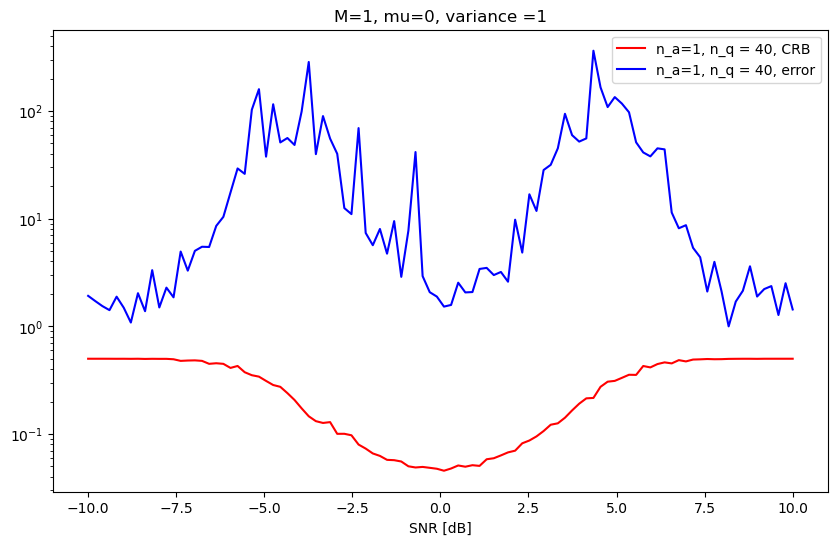

In [44]:
sim = pow(10,2)
n_a = [1,1,2,2]
n_q = [40,100,40,100]
#tao_list = [0] #M levels
matrix_const1 = Matrix(n_a[0],n_q[0])
matrix_const2 = Matrix(n_a[1],n_q[1])
matrix_const3 = Matrix(n_a[2],n_q[2])
matrix_const4 = Matrix(n_a[3],n_q[3])

thresh_real = thresh_G(n_q[0],matrix_const1[1])[0]
thresh_imag = thresh_G(n_q[0],matrix_const1[1])[1]
thresh_const = np.ones((M*n_q[0], 1))

#L_Estimator_analytic1 = [MSE_zertothresh_analytic(1, n_a[0],n_q[0]) for i in range(len(sigma_space))]
# L_Estimator_analytic2 = [MSE_zertothresh_analytic(sigma_space[i], n_a[1],n_q[1]) for i in range(len(sigma_space))]
# L_Estimator_analytic3 = [MSE_zertothresh_analytic(sigma_space[i], n_a[2],n_q[2]) for i in range(len(sigma_space))]
# L_Estimator_analytic4 = [MSE_zertothresh_analytic(sigma_space[i], n_a[3],n_q[3]) for i in range(len(sigma_space))]

L_Estimator_numerical1 = [MSE_general_numerical(1, n_a[0],n_q[0], matrix_const1, sim,thresh_space[i]*thresh_const,thresh_space[i]*thresh_const) for i in range(len(thresh_space))]
# L_Estimator_numerical2 = [MSE_general_numerical(sigma_space[i], n_a[0],n_q[1], matrix_const2, sim) for i in range(len(sigma_space))]
# L_Estimator_numerical3 = [MSE_general_numerical(sigma_space[i], n_a[1],n_q[0], matrix_const3, sim) for i in range(len(sigma_space))]
# L_Estimator_numerical4 = [MSE_general_numerical(sigma_space[i], n_a[1],n_q[1], matrix_const4, sim) for i in range(len(sigma_space))]

CRB2 = [CRB(1,n_a[0],n_q[0],matrix_const1,sim,thresh_space[i]*thresh_const,thresh_space[i]*thresh_const) for i in range(len(thresh_space))]
# CRB4 = [CRB(sigma_space[i],n_a[1],n_q[1],matrix_const2,100*sim,0,0) for i in range(len(sigma_space))]
# CRB6 = [CRB(sigma_space[i],n_a[2],n_q[2],matrix_const3,100*sim,0,0) for i in range(len(sigma_space))]
# CRB8 = [CRB(sigma_space[i],n_a[3],n_q[3],matrix_const4,100*sim,0,0) for i in range(len(sigma_space))]

#Etheta_numeric = [Etheta_numeric(sigma_space[i], n_a[0],n_q[0], matrix_const1, sim) for i in range(len(sigma_space))]
#CRB_M = [CRB_M_levels(sigma_space[i],matrix_const1, sim*100, tao_list, 0) for i in range(len(thresh_space))]
fig = plt.figure(figsize=(10, 6))
######################
# list_of_colors = ['red','blue','pink','black']
# list_of_functions = [CRB2,CRB4,CRB6,CRB8]
# for i in range(len(list_of_functions)):
#     plt.plot(10*np.log10(1/sigma_space), list_of_functions[i],".", color=list_of_colors[i], label='n_a={}, n_q = {}, CRB'.format(n_a[i], n_q[i]))

# list_of_functions1 = [L_Estimator_analytic1, L_Estimator_analytic2,L_Estimator_analytic3,L_Estimator_analytic4]
# for i in range(len(list_of_functions1)):
#     plt.plot(10*np.log10(1/sigma_space), list_of_functions1[i], color=list_of_colors[i], label='n_a={}, n_q = {}, numerical'.format(n_a[i], n_q[i]))

# list_of_functions2 = [L_Estimator_analytic1,L_Estimator_analytic2,L_Estimator_analytic3,L_Estimator_analytic4]
# for i in range(len(list_of_functions2)):
#     plt.plot(10*np.log10(1/sigma_space), list_of_functions2[i] ,color=list_of_colors[i], label='n_a={}, n_q = {}, analytic'.format(n_a[i], n_q[i]))

plt.plot(10*np.log10(1/sigma_space), CRB2, color="red", label='n_a={}, n_q = {}, CRB'.format(n_a[0], n_q[0]))
plt.plot(10*np.log10(1/sigma_space), L_Estimator_numerical1, color="blue", label='n_a={}, n_q = {}, error'.format(n_a[0], n_q[0]))
plt.title("M={}, mu={}, variance ={}".format(M,mu,round(2*pow(sigma_teta,2))))
plt.yscale('log')
plt.xlabel("SNR [dB]")
plt.legend()
plt.legend()
plt.show()